In [1]:
# %% 0) Setup
# ─────────────────────────────────────────────────────────────────────────────
%run setup.py  # adds project root and src/ to sys.path, exposes log_event, LogKind

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from pathlib import Path
from wordcloud import WordCloud
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfVectorizer,
    ENGLISH_STOP_WORDS as sk_stop,
)
from sklearn.metrics.pairwise import cosine_similarity
from tabulate import tabulate  # pip install tabulate
from src.logs import log_event, LogKind  # noqa: F401

In [2]:
# %% 1) Load data & sample for EDA
# ─────────────────────────────────────────────────────────────────────────────
train_df = (
    pd.read_csv("../data/splits/train.csv")
    .dropna(subset=["question1", "question2"])
)
# take ~10% sample for quick EDA
sampled = train_df.sample(n=32_000, random_state=13).copy()

# add basic length/word counts
sampled["q1_len"] = sampled["question1"].astype(str).apply(len)
sampled["q2_len"] = sampled["question2"].astype(str).apply(len)
sampled["q1_words"] = sampled["question1"].astype(str).apply(lambda x: len(x.split()))
sampled["q2_words"] = sampled["question2"].astype(str).apply(lambda x: len(x.split()))

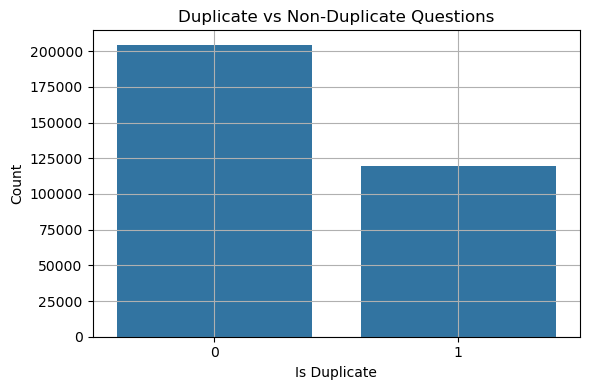

In [3]:
# %% 2) Class balance
# ─────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(6, 4))
sns.countplot(x="is_duplicate", data=train_df)
plt.title("Duplicate vs Non-Duplicate Questions")
plt.xlabel("Is Duplicate")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

# log class counts
dup_count = int(train_df["is_duplicate"].sum())
nondup_count = len(train_df) - dup_count
log_event(
    LogKind.EDA,
    eda="class_balance",
    dup_count=dup_count,
    nondup_count=nondup_count,
    dup_ratio=f"{train_df['is_duplicate'].mean():.3%}",
)

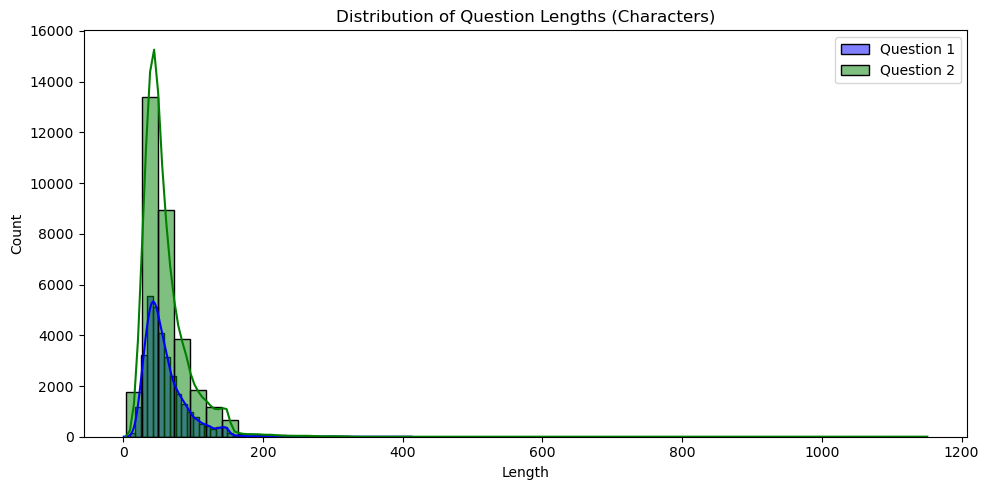

In [4]:
# %% 3) Distribution of question lengths (chars)
# ─────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(10, 5))
sns.histplot(sampled["q1_len"], bins=50, color="blue", label="Question 1", kde=True)
sns.histplot(sampled["q2_len"], bins=50, color="green", label="Question 2", kde=True)
plt.title("Distribution of Question Lengths (Characters)")
plt.xlabel("Length")
plt.legend()
plt.tight_layout()
plt.show()

# log mean lengths
mean_q1_len = sampled["q1_len"].mean()
mean_q2_len = sampled["q2_len"].mean()
log_event(
    LogKind.EDA,
    eda="char_length",
    mean_q1_len=f"{mean_q1_len:.1f}",
    mean_q2_len=f"{mean_q2_len:.1f}",
)

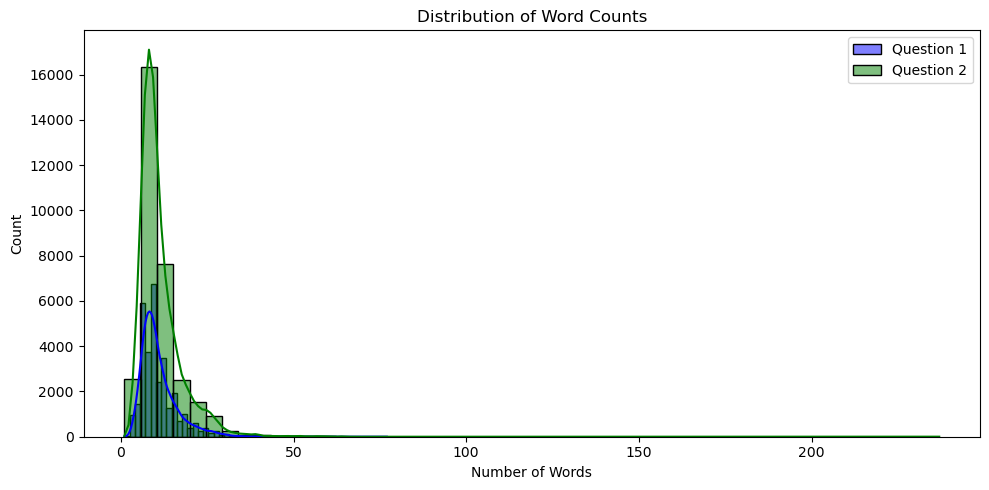

In [5]:
# %% 4) Distribution of word counts
# ─────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(10, 5))
sns.histplot(sampled["q1_words"], bins=50, color="blue", label="Question 1", kde=True)
sns.histplot(sampled["q2_words"], bins=50, color="green", label="Question 2", kde=True)
plt.title("Distribution of Word Counts")
plt.xlabel("Number of Words")
plt.legend()
plt.tight_layout()
plt.show()

# log mean word counts
mean_q1_words = sampled["q1_words"].mean()
mean_q2_words = sampled["q2_words"].mean()
log_event(
    LogKind.EDA,
    eda="word_count",
    mean_q1_words=f"{mean_q1_words:.1f}",
    mean_q2_words=f"{mean_q2_words:.1f}",
)

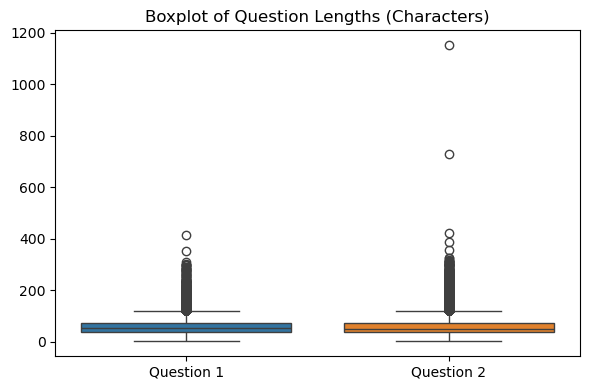

In [6]:
# %% 5) Boxplot of question lengths
# ─────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(6, 4))
sns.boxplot(data=sampled[["q1_len", "q2_len"]])
plt.title("Boxplot of Question Lengths (Characters)")
plt.xticks([0, 1], ["Question 1", "Question 2"])
plt.tight_layout()
plt.show()

# No logging needed here (visual only).

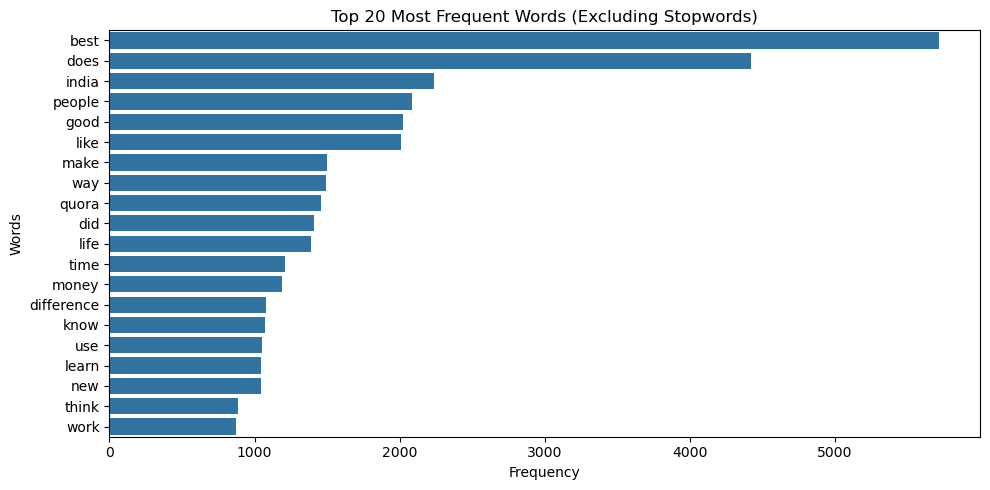

In [7]:
# %% 6) Top 20 frequent words (excluding stopwords)
# ─────────────────────────────────────────────────────────────────────────────
vectorizer = CountVectorizer(stop_words="english", max_features=20)
X_counts = vectorizer.fit_transform(sampled["question1"] + " " + sampled["question2"])
word_freq = (
    pd.DataFrame(
        X_counts.toarray(), columns=vectorizer.get_feature_names_out()
    )
    .sum()
    .sort_values(ascending=False)
)

plt.figure(figsize=(10, 5))
sns.barplot(x=word_freq.values, y=word_freq.index)
plt.title("Top 20 Most Frequent Words (Excluding Stopwords)")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.tight_layout()
plt.show()

# log top‐10 words and their frequencies
top_words = word_freq.head(10).to_dict()
for w, cnt in top_words.items():
    log_event(
        LogKind.EDA,
        eda="top_word",
        word=w,
        freq=int(cnt),
    )

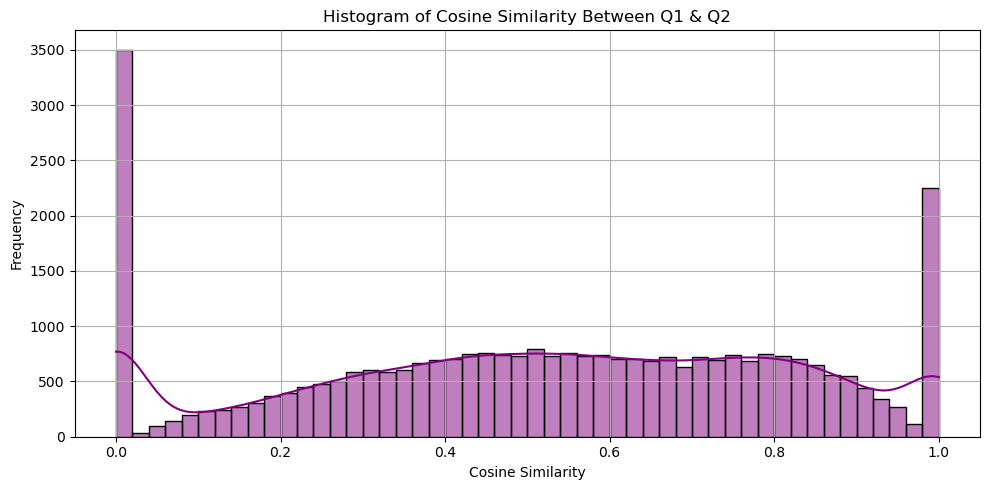

In [8]:
# %% 7) TF-IDF cosine similarity per pair
# ─────────────────────────────────────────────────────────────────────────────
tfidf = TfidfVectorizer(stop_words="english")
tfidf_q1 = tfidf.fit_transform(sampled["question1"])
tfidf_q2 = tfidf.transform(sampled["question2"])
sampled["cosine_similarity"] = [
    cosine_similarity(tfidf_q1[i], tfidf_q2[i])[0][0] for i in range(len(sampled))
]

plt.figure(figsize=(10, 5))
sns.histplot(
    sampled["cosine_similarity"], bins=50, kde=True, color="purple"
)
plt.title("Histogram of Cosine Similarity Between Q1 & Q2")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# log mean and std of cosine similarity
mean_cosine = sampled["cosine_similarity"].mean()
std_cosine = sampled["cosine_similarity"].std()
log_event(
    LogKind.EDA,
    eda="cosine_similarity",
    mean_cosine=f"{mean_cosine:.3f}",
    std_cosine=f"{std_cosine:.3f}",
)

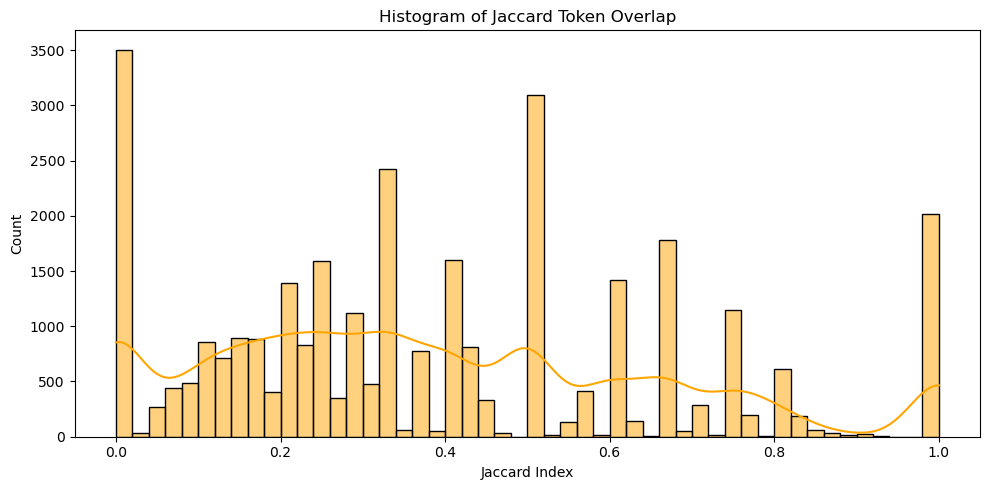

In [9]:
# %% 8) Jaccard token overlap
# ─────────────────────────────────────────────────────────────────────────────
tokeniser = re.compile(r"[A-Za-z0-9']+")

def jaccard(a: str, b: str) -> float:
    s1 = {t for t in tokeniser.findall(a.lower()) if t not in sk_stop}
    s2 = {t for t in tokeniser.findall(b.lower()) if t not in sk_stop}
    return len(s1 & s2) / (len(s1 | s2) or 1)

sampled["jaccard"] = sampled.apply(
    lambda r: jaccard(r.question1, r.question2), axis=1
)

plt.figure(figsize=(10, 5))
sns.histplot(sampled["jaccard"], bins=50, kde=True, color="orange")
plt.title("Histogram of Jaccard Token Overlap")
plt.xlabel("Jaccard Index")
plt.tight_layout()
plt.show()

# log mean Jaccard
mean_jaccard = sampled["jaccard"].mean()
log_event(
    LogKind.EDA, eda="jaccard_overlap", mean_jaccard=f"{mean_jaccard:.3f}"
)

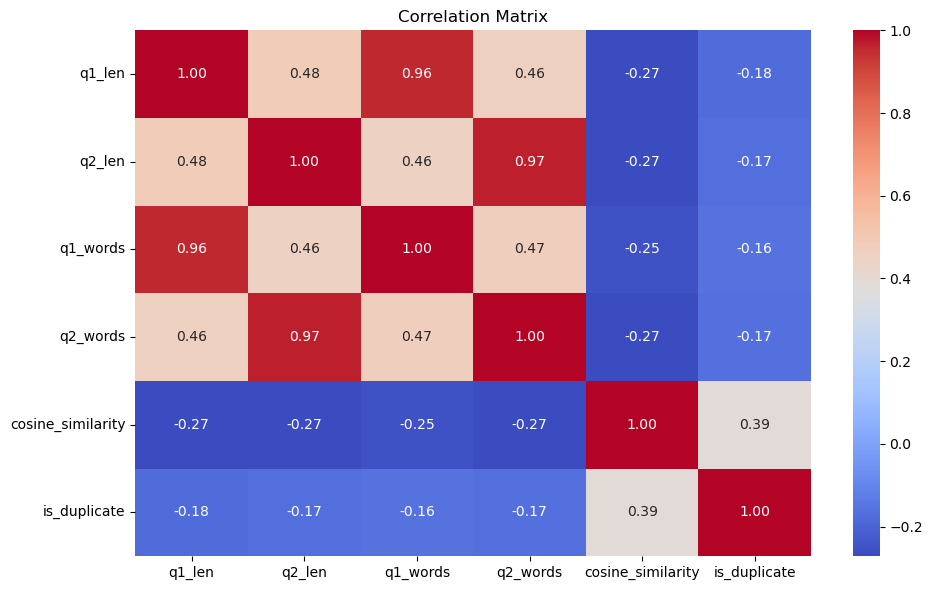

In [10]:
# %% 9) Correlation heatmap
# ─────────────────────────────────────────────────────────────────────────────
corr_matrix = sampled[
    ["q1_len", "q2_len", "q1_words", "q2_words", "cosine_similarity", "is_duplicate"]
].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

# log strongest correlations with is_duplicate
corr_with_dup = (
    corr_matrix["is_duplicate"]
    .drop("is_duplicate")
    .sort_values(key=abs, ascending=False)
)
for feature, corr_val in corr_with_dup.items():
    log_event(
        LogKind.EDA,
        eda="corr_with_dup",
        feature=feature,
        corr=f"{corr_val:.3f}",
    )

/tmp/ipykernel_9579/2446525629.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dup_rate_len = sampled.groupby(bins)["is_duplicate"].mean()


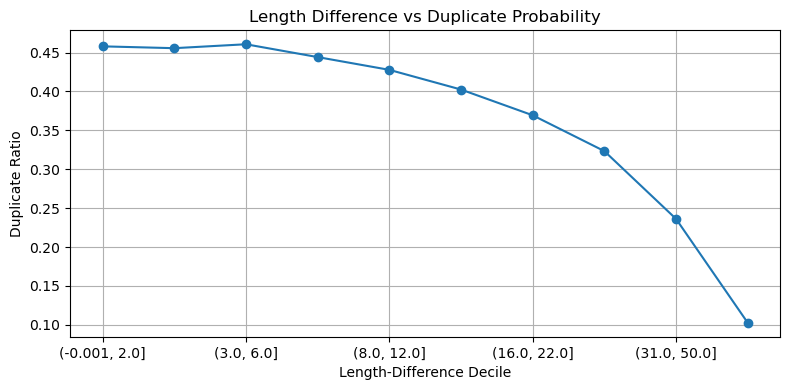

In [11]:
# %% 10) Length-difference vs duplicate rate
# ─────────────────────────────────────────────────────────────────────────────
sampled["len_diff"] = abs(sampled["q1_len"] - sampled["q2_len"])
bins = pd.qcut(sampled["len_diff"], 10, duplicates="drop")
dup_rate_len = sampled.groupby(bins)["is_duplicate"].mean()

plt.figure(figsize=(8, 4))
dup_rate_len.plot(marker="o")
plt.ylabel("Duplicate Ratio")
plt.xlabel("Length-Difference Decile")
plt.title("Length Difference vs Duplicate Probability")
plt.grid(True)
plt.tight_layout()
plt.show()

# log duplicate ratio by len_diff decile
for i, ((bin_range), ratio) in enumerate(dup_rate_len.items(), start=1):
    log_event(
        LogKind.EDA,
        eda="dup_rate_by_len_diff",
        decile=i,
        len_diff_range=str(bin_range),
        dup_ratio=f"{ratio:.3f}",
    )

In [12]:
# %% 11) Compute min_freq before summary
# ─────────────────────────────────────────────────────────────────────────────
# We need each question’s overall frequency (in train) to replicate the “magic” feature
freq = pd.concat([train_df.qid1, train_df.qid2]).value_counts()
sampled["q1_freq"] = sampled["qid1"].map(freq)
sampled["q2_freq"] = sampled["qid2"].map(freq)
sampled["min_freq"] = sampled[["q1_freq", "q2_freq"]].min(axis=1)

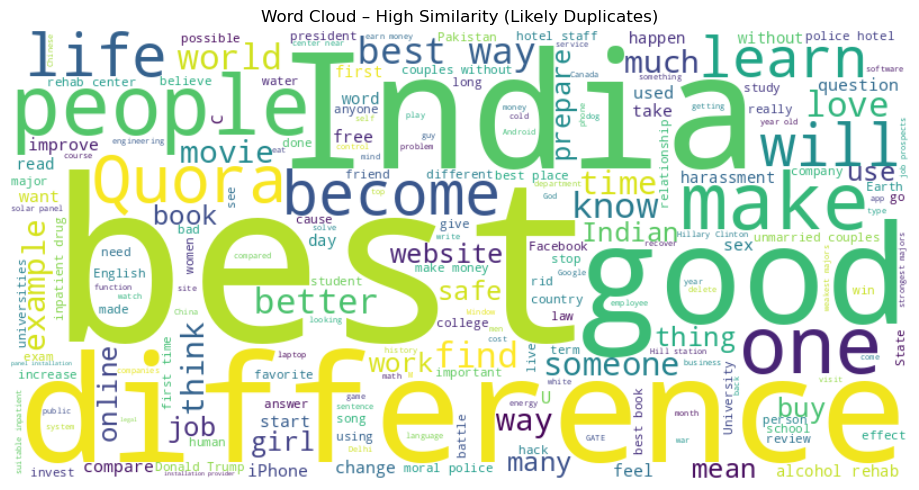

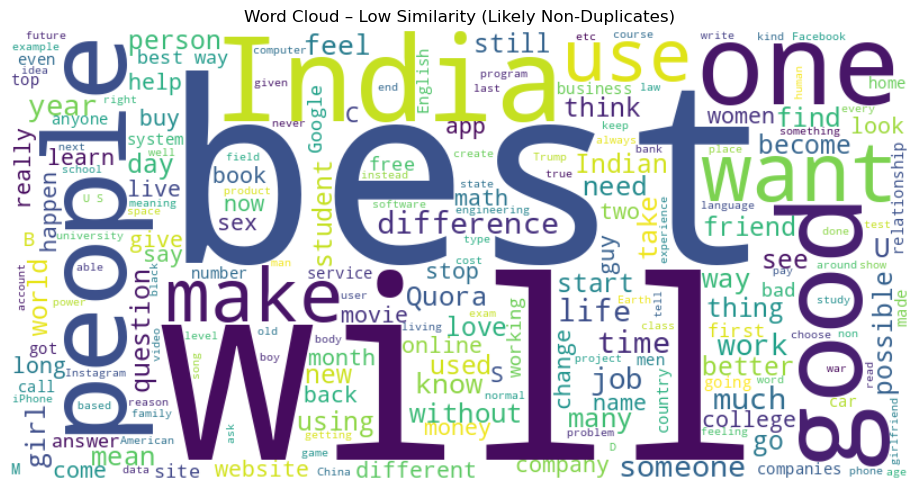

In [13]:
# %% 12) Word clouds for high/low similarity groups
# ─────────────────────────────────────────────────────────────────────────────
dup_text = (
    " ".join(sampled[sampled["cosine_similarity"] > 0.8]["question1"].astype(str))
    + " "
    + " ".join(sampled[sampled["cosine_similarity"] > 0.8]["question2"].astype(str))
)
nondup_text = (
    " ".join(sampled[sampled["cosine_similarity"] < 0.2]["question1"].astype(str))
    + " "
    + " ".join(sampled[sampled["cosine_similarity"] < 0.2]["question2"].astype(str))
)

# Word cloud for likely duplicates
wordcloud_dup = WordCloud(width=800, height=400, background_color="white").generate(dup_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_dup, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud – High Similarity (Likely Duplicates)")
plt.tight_layout()
plt.show()

# Word cloud for likely non-duplicates
wordcloud_nondup = WordCloud(width=800, height=400, background_color="white").generate(nondup_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_nondup, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud – Low Similarity (Likely Non-Duplicates)")
plt.tight_layout()
plt.show()

# No numeric logging for word clouds.

In [14]:
# %% 13) Summary table of key metrics
# ─────────────────────────────────────────────────────────────────────────────
corr_freq = sampled[["min_freq", "is_duplicate"]].corr().iloc[0, 1]

summary = pd.DataFrame(
    {
        "metric": [
            "train rows",
            "dup count",
            "non-dup count",
            "dup ratio",
            "mean q1 chars",
            "mean q2 chars",
            "mean q1 words",
            "mean q2 words",
            "mean len_diff",
            "mean Jaccard",
            "mean cosine TF-IDF",
            "corr(min_freq, is_dup)",
        ],
        "value": [
            len(train_df),
            int(train_df["is_duplicate"].sum()),
            int((1 - train_df["is_duplicate"]).sum()),
            f"{train_df['is_duplicate'].mean():.3%}",
            f"{mean_q1_len:.1f}",
            f"{mean_q2_len:.1f}",
            f"{mean_q1_words:.1f}",
            f"{mean_q2_words:.1f}",
            f"{sampled["len_diff"].mean():.1f}",
            f"{mean_jaccard:.3f}",
            f"{mean_cosine:.3f}",
            f"{corr_freq:.3f}",
        ],
    }
)

print(tabulate(summary, headers="keys", tablefmt="github", showindex=False))

# also write to a file for downstream reference
out_fp = Path("../metric_logs/eda_summary.csv")
summary.to_csv(out_fp, index=False)

# log that summary was written
log_event(
    LogKind.EDA,
    eda="summary_table",
    summary_file=str(out_fp.resolve()),
)

| metric                 | value   |
|------------------------|---------|
| train rows             | 323613  |
| dup count              | 119283  |
| non-dup count          | 204330  |
| dup ratio              | 36.860% |
| mean q1 chars          | 59.7    |
| mean q2 chars          | 60.5    |
| mean q1 words          | 11.0    |
| mean q2 words          | 11.3    |
| mean len_diff          | 20.3    |
| mean Jaccard           | 0.387   |
| mean cosine TF-IDF     | 0.520   |
| corr(min_freq, is_dup) | 0.406   |


In [15]:
# %% 14) Detailed correlations & bin analyses
# ─────────────────────────────────────────────────────────────────────────────
# A) Correlations of signal features with is_duplicate
corr_signals = sampled[
    ["jaccard", "cosine_similarity", "len_diff", "q1_len", "q2_len", "is_duplicate"]
].corr()["is_duplicate"].drop("is_duplicate")
print("\nCorrelation w/ is_duplicate:")
print(corr_signals.round(3).to_string())

# B) Duplicate ratio by len_diff decile (already logged above)

# C) Duplicate ratio by min_freq quartile
quart = pd.qcut(sampled["min_freq"], 4, duplicates="drop")
dup_rate_freq = (
    sampled.groupby(quart)["is_duplicate"].mean().to_frame("dup_ratio")
)
print("\nDuplicate ratio by min_freq quartile:")
print(tabulate(dup_rate_freq.reset_index(), headers="keys", tablefmt="github", showindex=False))

# log duplicates by freq quartile
for i, (_, row) in enumerate(dup_rate_freq.reset_index().iterrows(), start=1):
    log_event(
        LogKind.EDA,
        eda="dup_rate_by_min_freq",
        quartile=i,
        freq_range=str(row["min_freq"]),
        dup_ratio=f"{row['dup_ratio']:.3f}",
    )

# D) Duplicate ratio by similarity deciles
for col in ["cosine_similarity", "jaccard"]:
    bins_sim = pd.qcut(sampled[col], 10, duplicates="drop")
    rate_sim = sampled.groupby(bins_sim)["is_duplicate"].mean().to_frame("dup_ratio")
    print(f"\nDuplicate ratio by {col} decile:")
    print(tabulate(rate_sim.reset_index(), headers="keys", tablefmt="github", showindex=False))
    # log each decile
    for j, (_, row) in enumerate(rate_sim.reset_index().iterrows(), start=1):
        log_event(
            LogKind.EDA,
            eda=f"dup_rate_by_{col}_decile",
            decile=j,
            sim_range=str(row[col]),
            dup_ratio=f"{row['dup_ratio']:.3f}",
        )


Correlation w/ is_duplicate:
jaccard              0.397
cosine_similarity    0.389
len_diff            -0.218
q1_len              -0.179
q2_len              -0.168

Duplicate ratio by min_freq quartile:
| min_freq     |   dup_ratio |
|--------------|-------------|
| (0.999, 2.0] |    0.252766 |
| (2.0, 51.0]  |    0.866016 |

Duplicate ratio by cosine_similarity decile:
| cosine_similarity   |   dup_ratio |
|---------------------|-------------|
| (-0.001, 0.247]     |   0.0529688 |
| (0.247, 0.36]       |   0.241875  |
| (0.36, 0.45]        |   0.339687  |
| (0.45, 0.536]       |   0.4       |
| (0.536, 0.623]      |   0.474375  |
| (0.623, 0.717]      |   0.502812  |
| (0.717, 0.805]      |   0.480625  |
| (0.805, 0.909]      |   0.480312  |
| (0.909, 1.0]        |   0.680625  |

Duplicate ratio by jaccard decile:
| jaccard         |   dup_ratio |
|-----------------|-------------|
| (-0.001, 0.143] |   0.0191836 |
| (0.143, 0.2]    |   0.183094  |
| (0.2, 0.286]    |   0.365079  |
| 

/tmp/ipykernel_9579/1709127651.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sampled.groupby(quart)["is_duplicate"].mean().to_frame("dup_ratio")
/tmp/ipykernel_9579/1709127651.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate_sim = sampled.groupby(bins_sim)["is_duplicate"].mean().to_frame("dup_ratio")
/tmp/ipykernel_9579/1709127651.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate_sim = sampled.gro